In [29]:
%matplotlib inline

import gdal
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import matplotlib.pyplot as plt
import numpy as np

## Explore and Crop the National Land Cover Database Raster

Exploring and Mapping the Raster

In [30]:
NLCD = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\NLCD\NLCD2011_LC_New_Jersey\NLCD2011_LC_New_Jersey.tif'

In [77]:
# Check coordinate system and exclude values outside of the land cover classification numbers
with rasterio.open(NLCD) as nlcd_raster:
    crs = nlcd_raster.crs
    nlcd = nlcd_raster.read(1)
    nlcd = nlcd.astype('f4')
    nlcd[nlcd>95] = np.nan

crs

CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True})

Text(0,0.5,'Row #')

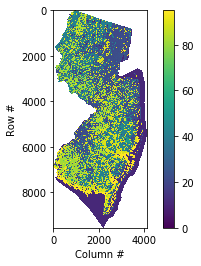

In [71]:
# Map array
plt.imshow(nlcd)
plt.colorbar()
plt.xlabel('Column #')
plt.ylabel('Row #')


In [75]:
print(nlcd[6000][3000])

42.0


In [78]:
# Create a function to only identify residential land
res_values =  [22, 23, 24]
non_res_values = [11,12,21,31,41,42,43,51,52,71,72,81,82,90,95]

def identify_res_land(array):
    for val in res_values:
        array[array==val] = 1.0
    for val in non_res_values:
        array[array==val] = 0.0
        
    return array

In [54]:
type(nlcd)

numpy.ndarray

Text(0,0.5,'Row #')

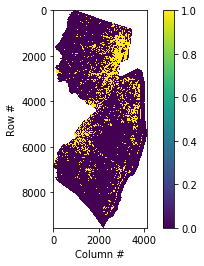

In [82]:
# Map array
nj_res_land = identify_res_land(nlcd)

plt.imshow(nj_res_land)
leg = plt.colorbar()
plt.xlabel('Column #')
plt.ylabel('Row #')